# Clustering Model Output


In [1]:
!pip install pyyaml h5py

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
from glob import glob
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import Tensor
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from typing import Union, List
from sklearn.preprocessing import StandardScaler

data_dir = 'gtzan/data/genres'

2024-05-06 21:41:13.712127: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 21:41:13.753951: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Hyperparameters

HOPS=192               #hop size (window size = 6*hop)
SR=16000              #sampling rate
MIN_LEVEL_DB=-100     #reference values to normalize data
REF_LEVEL_DB=20

SHAPE=24              #length of time axis of split specrograms to feed to generator            
VEC_LEN=128           #length of vector generated by siamese vector
BS = 16               #batch size
DELTA = 2.            #constant for siamese loss

In [4]:
#Adding Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
import tensorflow.python.ops as ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape

#Function to calculate the l2 norm of a vector
#v - input vector
#eps - parameter to help with numerical stability
def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


#Convolutional Layer with Spectral Normalization
class ConvSN2D(tf.keras.layers.Conv2D):
    
    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(name=self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        
        self.u.assign(new_u)
        with tf.control_dependencies([self.u]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self.convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs


#Transposed Convolutional Layer with Spectral Normalization
# *This performs Deconvolution
class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(name=self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        
        self.u.assign(new_u)
        with tf.control_dependencies([self.u]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
        else:
          h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
          out_pad_h = out_pad_w = None
        else:
          out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
          output_shape = (batch_size, self.filters, out_height, out_width)
        else:
          output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = tf.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
          out_shape = self.compute_output_shape(inputs.shape)
          outputs.set_shape(out_shape)

        if self.use_bias:
          outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
          return self.activation(outputs)
        return outputs  
    

#Dense Layer with Spectral Normalization
class DenseSN(Dense):
    
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(name=self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        
        self.u.assign(new_u)
        with tf.control_dependencies([self.u]):
          W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
          outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [self.units]
            outputs.set_shape(output_shape)
        else:
          inputs = math_ops.cast(inputs, self.compute_dtype)
          if K.is_sparse(inputs):
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
          else:
            outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
          outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
          return self.activation(outputs)
        return outputs


In [5]:
#Networks Architecture

init = tf.keras.initializers.he_uniform()

#Function to abstract creation and calling of a Convolutional Layer
#leaky - use LeakyReLU or ReLU
#bnorm - use BatchNormalization
#sn - include or exclude spectral normalization
#layer_input - the input to the call() method
#other parameters - TensorFlow-like Conv2D parameters
def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
  if leaky:
    Activ = LeakyReLU(alpha=0.2)
  else:
    Activ = ReLU()
  if sn:
    d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  else:
    d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  if bnorm:
    d = BatchNormalization()(d)
  d = Activ(d)
  return d

#Function to abstract creation and calling of a Convolutional Layer
#up - up sample with ConvSN2D, or use ConvSN2DTranspose
#bnorm - use BatchNormalization
#conc - use a Concatenation layer
#layer_input - the input to the call() method
#other parameters - TensorFlow-like Conv2D parameters
def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
  if up:
    u = UpSampling2D((1,2))(layer_input)
    u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
  else:
    u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
  if bnorm:
    u = BatchNormalization()(u)
  u = LeakyReLU(alpha=0.2)(u)
  if conc:
    u = Concatenate()([u,layer_res])
  return u

In [6]:
#U-NET style architecture
def build_generator(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  #downscaling
  g0 = tf.keras.layers.ZeroPadding2D((0,1))(inp)
  g1 = conv2d(g0, 256, kernel_size=(h,3), strides=1, padding='valid')
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
  #upscaling
  g4 = deconv2d(g3,g2, 256, kernel_size=(1,7), strides=(1,2))
  g5 = deconv2d(g4,g1, 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), kernel_initializer=init, padding='valid', activation='tanh')(g5)
  return Model(inp,g6, name='G')

#Siamese Network
def build_siamese(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid', sn=False)
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2), sn=False)
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2), sn=False)
  g4 = Flatten()(g3)
  g5 = Dense(VEC_LEN)(g4)
  return Model(inp, g5, name='S')

#Discriminator (Critic) Network
def build_critic(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
  g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
  g4 = Flatten()(g3)
  g4 = DenseSN(1, kernel_initializer=init)(g4)
  return Model(inp, g4, name='C')

#Load past models from path to resume training or test
def load(path):
    gen = build_generator((HOPS,SHAPE,1))
    siam = build_siamese((HOPS,SHAPE,1))
    critic = build_critic((HOPS,3*SHAPE,1))
    gen.load_weights(path+'/gen.weights.h5')
    critic.load_weights(path+'/critic.weights.h5')
    siam.load_weights(path+'/siam.weights.h5')
    return gen,critic,siam

In [7]:
#Normalize a spectral sample
def normalize(S):
    return np.clip((((S - MIN_LEVEL_DB) / -MIN_LEVEL_DB)*2.)-1., -1, 1)

#Generate Mel-Spectrogram given audio sample with sr sample rate
def melspecfunc(waveform: Tensor) -> Tensor:
    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(
        waveform,
        nfft=6*HOPS,
        window=6*HOPS,
        stride=HOPS
    )

    
    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(
        spectrogram, 
        rate=SR, 
        mels=HOPS,
        fmin=0, 
        fmax=SR // 2
    )
    mel_spectrogram = tf.transpose(mel_spectrogram) # ADDED
    return mel_spectrogram

#Prep a waveform, by creating its Mel-Spectrogram then normalizing it
def prep(waveform: np.ndarray, hop: int = 192) -> Tensor:
    scaled_waveform = tf.cast(waveform, tf.float32) # uint16 max
    mel_spectrogram = melspecfunc(scaled_waveform) # calculate mel spectogram
#     print(mel_spectrogram.shape)
    dbscale_mel_spectrogram = mel_spectrogram - REF_LEVEL_DB # center on ref level
    dbscale_mel_spectrogram = normalize(dbscale_mel_spectrogram) # normalize
    return dbscale_mel_spectrogram

#Deprpep a normalized Mel-Spectrogram, by denormalizing it and then generating a waveform using the GRAD function
def deprep(mel_spectrogram: Tensor) -> np.ndarray:
    mel_spectrogram = denormalize(mel_spectrogram)+REF_LEVEL_DB
    mel_spectrogram = 10.0**(mel_spectrogram / 10)
    wv = GRAD(np.expand_dims(mel_spectrogram, 0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8)
    return np.array(np.squeeze(wv))

#Assembling generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
    but=False
    con = np.array([])
    nim = a.shape[0]
    for i in range(nim-1):
        im = a[i]
        im = np.squeeze(im)
        if not but:
            con=im
            but=True
        else:
            con = np.concatenate((con,im), axis=1)
    diff = spec.shape[1]-(nim*SHAPE)
    a = np.squeeze(a)
    con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
    return np.squeeze(con)

# Split spectrograms in chunks with equal size
def splitcut(data: np.ndarray) -> np.ndarray:
  ls = []
  mini = 0
  minifinal = 10*SHAPE                                                              #max spectrogram length
  for i in range(data.shape[0]-1):
    if data[i].shape[1]<=data[i+1].shape[1]:
      mini = data[i].shape[1]
    else:
      mini = data[i+1].shape[1]
    
    # bind minifinal between [3*shape, 10*shape]
    if mini>=3*SHAPE and mini<minifinal:
      minifinal = mini

  for i in range(data.shape[0]):
    x = data[i]
    if x.shape[1]>=3*SHAPE:
      # splits into chunks of length minifinal
      for n in range(x.shape[1]//minifinal):
        ls.append(x[:,n*minifinal:(n+1)*minifinal,:])
      # pads last partial chunk
      ls.append(x[:,-minifinal:,:])
  return np.array(ls)

#Extract function: splitting spectrograms
def extract_image(im):
  im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
  im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
  im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
  return [im1,im2,im3]

#Generate spectrograms from waveform array
#data - either a NumPy array or a list of NumPy arrays
def tospec(data: Union[np.ndarray, List[np.ndarray]]) -> np.ndarray:
    specs=np.empty(data.shape[0], dtype=object)
    for i in range(data.shape[0]):
        x = data[i]
        S = prep(x)
        S = np.array(S, dtype=np.float32)
        specs[i]=np.expand_dims(S, -1)
    print(specs.shape)
    return specs

#Waveform array from path of folder containing wav files
def audio_array(path: str) -> np.ndarray:
    ls = glob(f'{path}/*.wav')
    ls = ls[:10] # SAMPLE 10 SONGS, COMMENT FOR WHOLE GENRE
    print(ls)
    adata = []
    for i in range(len(ls)):
        audio = tfio.audio.AudioIOTensor(ls[i])
        audio_tensor = tf.squeeze(audio.to_tensor(), axis=-1)
        x_np = audio_tensor.numpy() / 32768.0
        adata.append(x_np)
    return np.stack(pad_sequences(adata, dtype='float32'))

def test_gen(gen, a_spec):
    #splitting spectrogram in 3 parts
    a_chop = extract_image(a_spec) 

    fabs = []
    #translating A to B
    for chop in a_chop:
#         print(chop.shape)
        fab = gen(chop, training=True)
        fabs.append(fab)

    fab_assemble = specass(np.array(fabs), a_spec)
    return fab_assemble

## Load Model


In [8]:
gen, critic, siam = load('./models/MELGANVC-0.2316760-0.7883532-0.0428976')

2024-05-06 21:41:16.315478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13797 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:61:00.0, compute capability: 7.5
/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Extract Spectrograms

In [9]:
#rock MUSIC
awv = audio_array('./gtzan/data/genres/rock')
aspec = tospec(awv)
adata = splitcut(aspec)
adata_extract = extract_image(adata)
adata_assemble = specass(np.array(adata_extract), adata)

#metal MUSIC
bwv = audio_array('./gtzan/data/genres/metal')
bspec = tospec(bwv)
bdata = splitcut(bspec)
bdata_extract = extract_image(bdata)
bdata_assemble = specass(np.array(bdata_extract), bdata)

['./gtzan/data/genres/rock/rock.00011.wav', './gtzan/data/genres/rock/rock.00005.wav', './gtzan/data/genres/rock/rock.00039.wav', './gtzan/data/genres/rock/rock.00038.wav', './gtzan/data/genres/rock/rock.00004.wav', './gtzan/data/genres/rock/rock.00010.wav', './gtzan/data/genres/rock/rock.00006.wav', './gtzan/data/genres/rock/rock.00012.wav', './gtzan/data/genres/rock/rock.00013.wav', './gtzan/data/genres/rock/rock.00007.wav']


2024-05-06 21:41:17.822823: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA


(10,)
['./gtzan/data/genres/metal/metal.00022.wav', './gtzan/data/genres/metal/metal.00036.wav', './gtzan/data/genres/metal/metal.00037.wav', './gtzan/data/genres/metal/metal.00023.wav', './gtzan/data/genres/metal/metal.00009.wav', './gtzan/data/genres/metal/metal.00035.wav', './gtzan/data/genres/metal/metal.00021.wav', './gtzan/data/genres/metal/metal.00020.wav', './gtzan/data/genres/metal/metal.00034.wav', './gtzan/data/genres/metal/metal.00008.wav']
(10,)


In [10]:
@tf.function
def proc(x):
  return tf.image.random_crop(x, size=[HOPS, 3*SHAPE, 1])

In [11]:
X_a =\
    np.stack(
        pad_sequences(
            adata,
            dtype='float32'
        )
    )

dsa = tf.data.Dataset\
    .from_tensor_slices(X_a)\
    .map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
    .batch(1, drop_remainder=True)

X_b =\
    np.stack(
        pad_sequences(
            bdata,
            dtype='float32'
        )
    )

dsb = tf.data.Dataset\
    .from_tensor_slices(X_b)\
    .map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
    .batch(1, drop_remainder=True)


## Testing Generator

In [12]:
adata.shape

(150, 192, 240, 1)

In [13]:
X_a.shape

(150, 192, 240, 1)

In [14]:
transferred_spectrograms = []
for batchi,(a,b) in enumerate(zip(dsa,dsb)):
#     print(a.shape)
    ass_spec = test_gen(gen, a)
#     print(ass_spec.shape)
    transferred_spectrograms.append(ass_spec)

2024-05-06 21:41:19.323152: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [150,192,240,1]
	 [[{{node Placeholder/_0}}]]
2024-05-06 21:41:19.385129: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [150,192,240,1]
	 [[{{node Placeholder/_0}}]]
2024-05-06 21:41:19.436169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901


In [15]:
X_gen = np.stack(pad_sequences(np.array(transferred_spectrograms), dtype='float32'))

In [16]:
X_gen.shape

(150, 192, 72)

In [17]:
bdata_assemble.shape

(150, 504, 80)

In [18]:
flat_X_gen = X_gen.reshape(X_gen.shape[0], X_gen.shape[1]*X_gen.shape[2])
flat_X_gen.shape

(150, 13824)

In [19]:
flat_bdata = bdata_assemble.reshape(bdata_assemble.shape[0], bdata_assemble.shape[1]*bdata_assemble.shape[2])
flat_bdata.shape

(150, 40320)

In [20]:
flat_adata = adata_assemble.reshape(adata_assemble.shape[0], adata_assemble.shape[1]*adata_assemble.shape[2])
flat_adata.shape

(150, 40320)

In [21]:
flat_data = np.stack(pad_sequences(flat_adata.tolist() + flat_bdata.tolist() + flat_X_gen.tolist()))
flat_data.shape

(450, 40320)

In [22]:
genres = ['rock', 'metal', 'T_metal']
data_list = [flat_adata.tolist(), flat_bdata.tolist(), flat_X_gen.tolist()]
y = np.concatenate([np.full(len(data_list[i]), g) for i, g in zip(range(len(genres)), genres)])
y.shape

(450,)

## Clustering

In [23]:
scaled_flat_data = StandardScaler().fit_transform(flat_data)

In [24]:
pca = PCA()
pca_X = pca.fit_transform(scaled_flat_data)

In [25]:
tsne = TSNE()
tsne_X = tsne.fit_transform(scaled_flat_data)

In [26]:
# Isomap reduction
isomap = Isomap(n_components=25)
isomap_X = isomap.fit_transform(scaled_flat_data)

In [27]:
# Locally linear embedding
lle = LocallyLinearEmbedding(n_components=25)
lle_X = lle.fit_transform(scaled_flat_data)

In [28]:
n_clusters = 2

tsne_kmeans = KMeans(n_clusters).fit(tsne_X)
tsne_clusters = tsne_kmeans.labels_

pca_kmeans = KMeans(n_clusters).fit(pca_X)
pca_clusters = pca_kmeans.labels_

isomap_kmeans = KMeans(n_clusters).fit(isomap_X)
isomap_clusters = isomap_kmeans.labels_

lle_kmeans = KMeans(n_clusters).fit(lle_X)
lle_clusters = lle_kmeans.labels_

# Ward unstructured heirarchical clustering
pca_ward_heir = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(pca_X)
pca_ward_labels = pca_ward_heir.labels_

tsne_ward_heir = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(tsne_X)
tsne_ward_labels = tsne_ward_heir.labels_

isomap_ward_heir = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(isomap_X)
isomap_ward_labels = isomap_ward_heir.labels_

lle_ward_heir = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(lle_X)
lle_ward_labels = lle_ward_heir.labels_

# Spectral Clustering
tsne_spectral = SpectralClustering(n_clusters).fit(tsne_X)
tsne_spec_clust = tsne_spectral.labels_

pca_spectral = SpectralClustering(n_clusters).fit(pca_X)
pca_spec_clust = pca_spectral.labels_

isomap_spectral = SpectralClustering(n_clusters).fit(isomap_X)
isomap_spec_clust = isomap_spectral.labels_

lle_spectral = SpectralClustering(n_clusters).fit(lle_X)
lle_spec_clust = lle_spectral.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_e

In [29]:
def make_plots(reduced_X, or_genres, kmean_clabel, ward_h_clabel, spec_clabel, reduce_method):
    ## Plot All Three Clustering Methods in One Figure ## 
    fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    for i, genre in enumerate(np.unique(or_genres)):
        indices = np.where(or_genres == genre)[0]
        axs[0].scatter(reduced_X[indices, 0], reduced_X[indices, 1], label=genre, alpha=0.3)

    axs[0].legend()
    axs[0].set_xlabel('Component 1')
    axs[0].set_ylabel('Component 2')
    axs[0].set_title(reduce_method)

    for i, cluster in enumerate(np.unique(kmean_clabel)):
        indices = np.where(kmean_clabel == cluster)[0]
        axs[1].scatter(reduced_X[indices, 0], reduced_X[indices, 1], label=cluster, alpha=0.3)

    axs[1].legend()
    axs[1].set_xlabel('Component 1')
    axs[1].set_title(f'{reduce_method} KMeans Clusters')

    for i, cluster in enumerate(np.unique(ward_h_clabel)):
        indices = np.where(ward_h_clabel == cluster)[0]
        axs[2].scatter(reduced_X[indices, 0], reduced_X[indices, 1], label=cluster, alpha=0.3)

    axs[2].legend()
    axs[2].set_xlabel('Component 1')
    axs[2].set_title(f'{reduce_method} Hierarchical Clusters')
    
    for i, cluster in enumerate(np.unique(spec_clabel)):
        indices = np.where(spec_clabel == cluster)[0]
        axs[3].scatter(reduced_X[indices, 0], reduced_X[indices, 1], label=cluster, alpha=0.3)

    axs[3].legend()
    axs[3].set_xlabel('Component 1')
    axs[3].set_title(f'{reduce_method} Spectral Clusters')

    plt.tight_layout()
    plt.show()
    
    ## First Plot ##
    for i, genre in enumerate(np.unique(or_genres)):
        indices = np.where(or_genres == genre)[0]
        plt.scatter(reduced_X[indices, 0], reduced_X[indices, 1], label=genre, alpha=0.3)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(reduce_method)
    plt.legend()
    plt.show()
    
    ## Second Plot ##
    for i, cluster in enumerate(np.unique(kmean_clabel)):
        indices = np.where(kmean_clabel == cluster)[0]
        plt.scatter(reduced_X[indices, 0], reduced_X[indices, 1], label=cluster, alpha=0.3)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'{reduce_method} KMeans Clusters')
    plt.legend()
    plt.show()
    
    ## Third Plot ## 
    for i, cluster in enumerate(np.unique(ward_h_clabel)):
        indices = np.where(ward_h_clabel == cluster)[0]
        plt.scatter(reduced_X[indices, 0], reduced_X[indices, 1], label=cluster, alpha=0.3)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'{reduce_method} Hierarchical Clusters')
    plt.legend()
    plt.show()
    
    ## Fourth Plot ## 
    for i, cluster in enumerate(np.unique(spec_clabel)):
        indices = np.where(spec_clabel == cluster)[0]
        plt.scatter(reduced_X[indices, 0], reduced_X[indices, 1], label=cluster, alpha=0.3)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'{reduce_method} Spectral Clusters')
    plt.legend()
    plt.show()

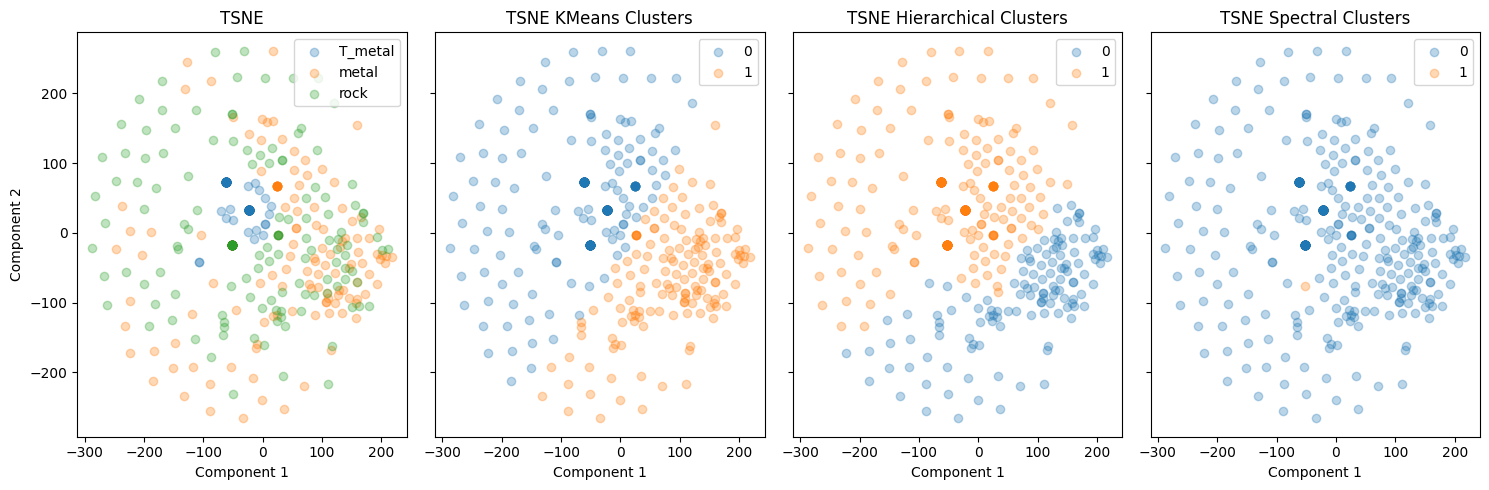

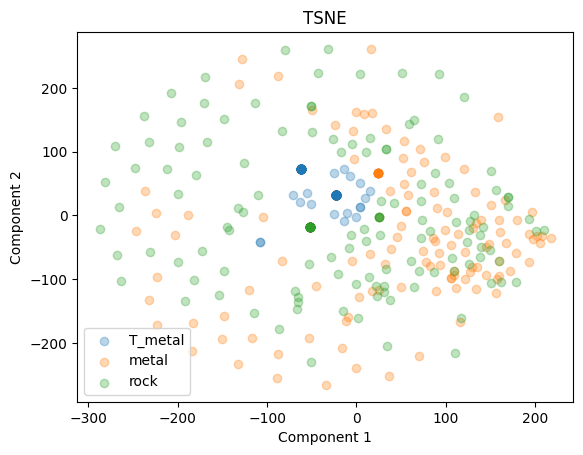

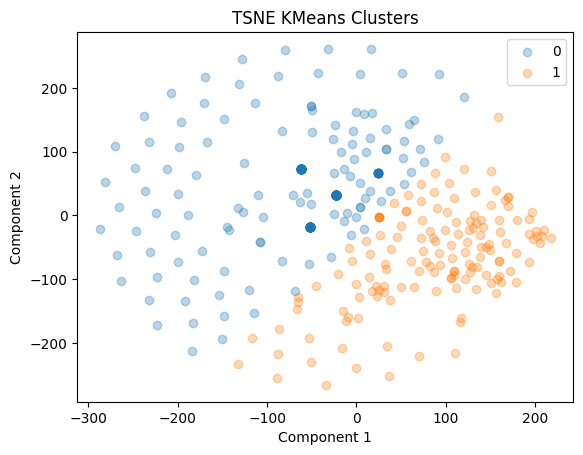

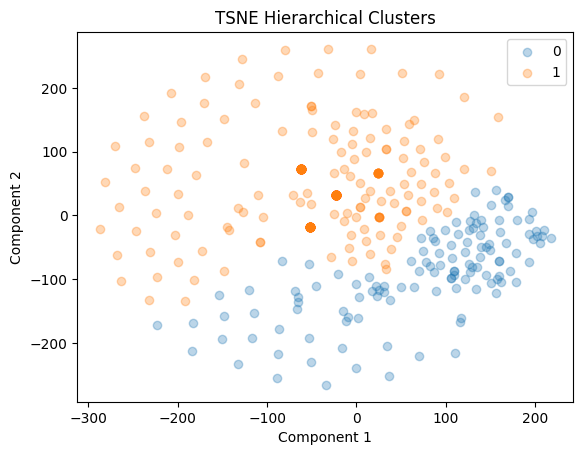

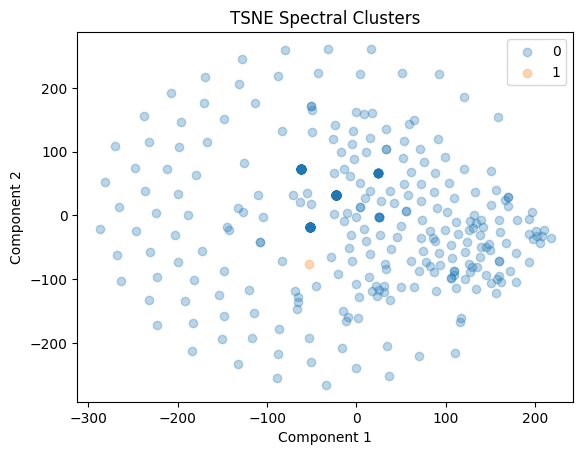

In [30]:
make_plots(tsne_X, y, tsne_clusters, tsne_ward_labels, tsne_spec_clust, 'TSNE')

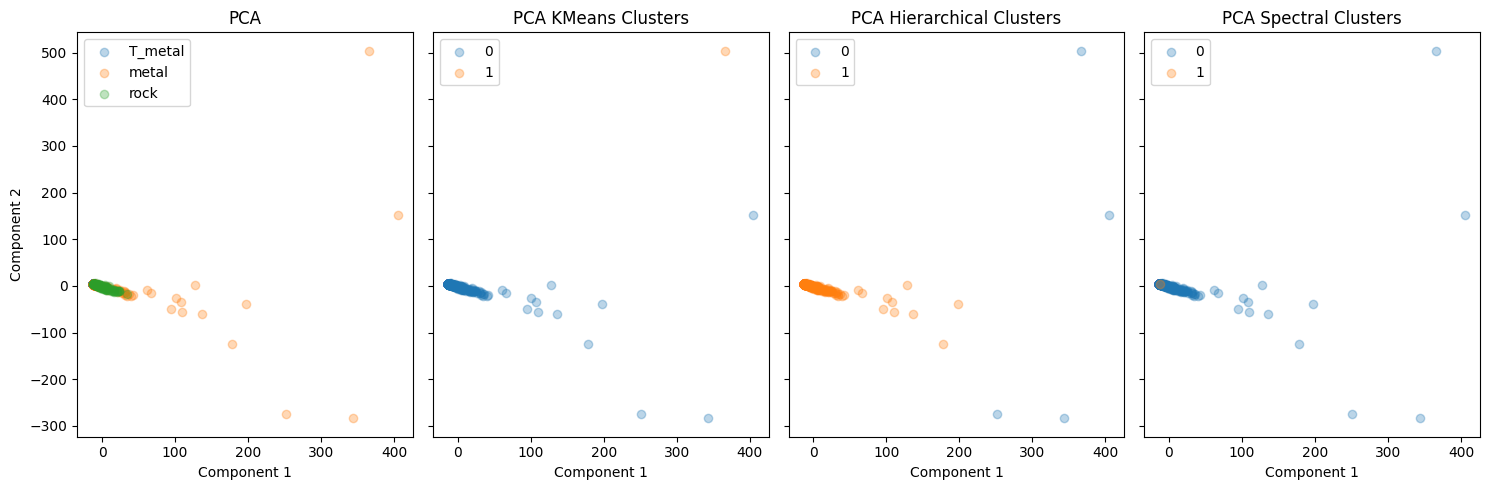

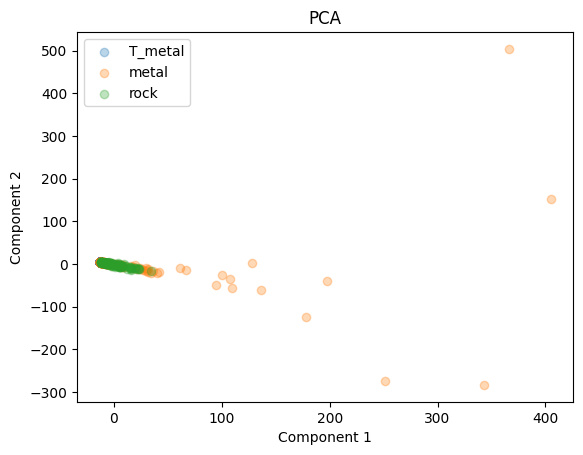

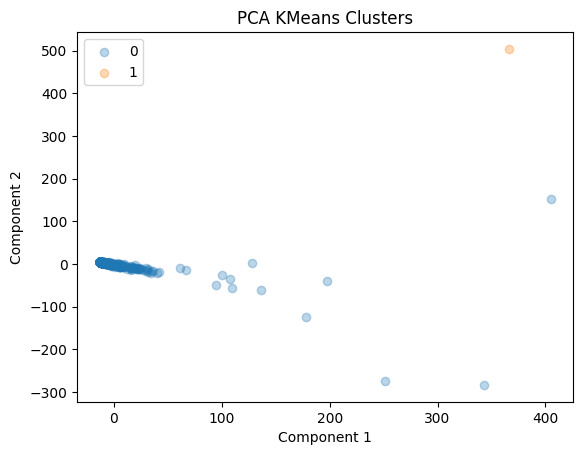

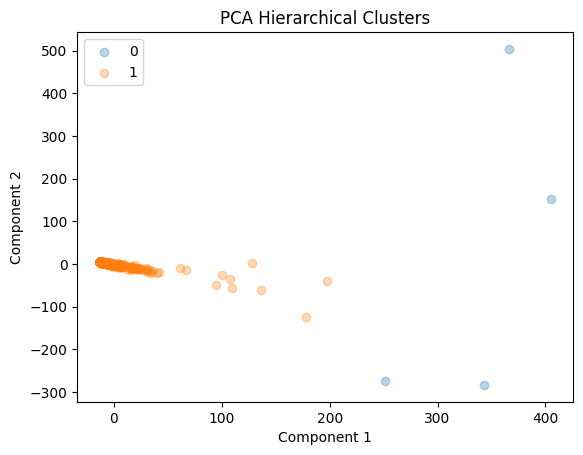

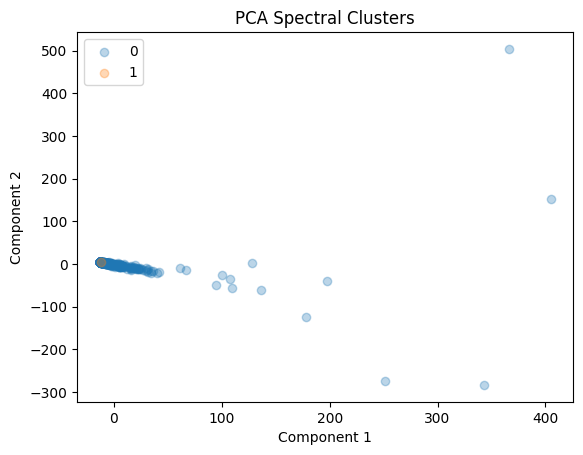

In [31]:
make_plots(pca_X, y, pca_clusters, pca_ward_labels, pca_spec_clust, 'PCA')

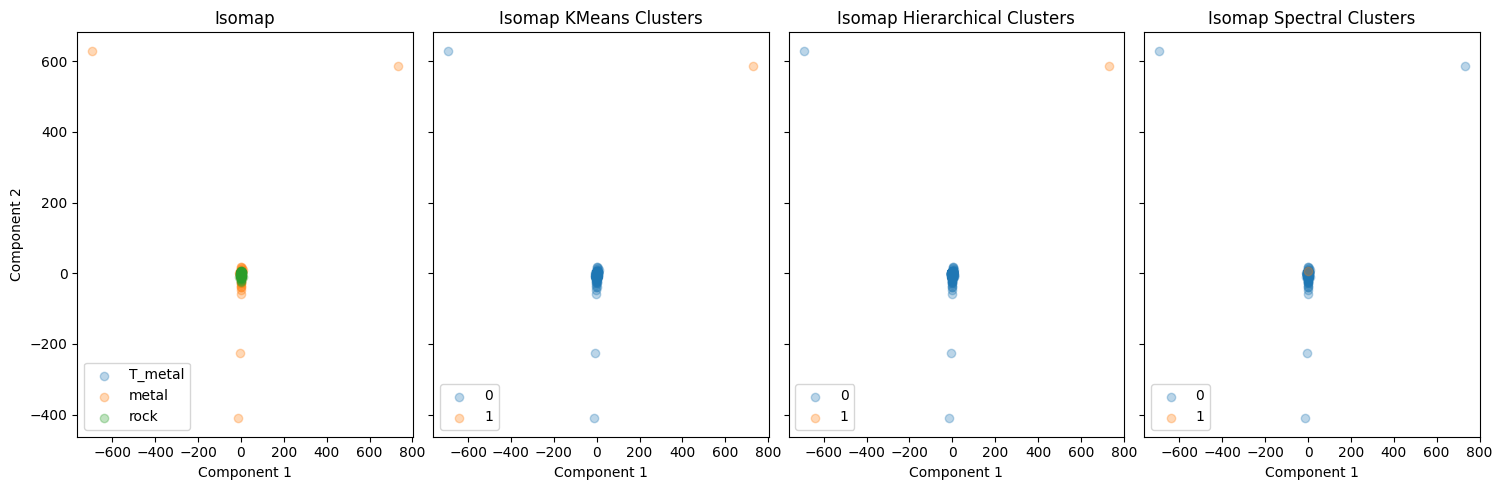

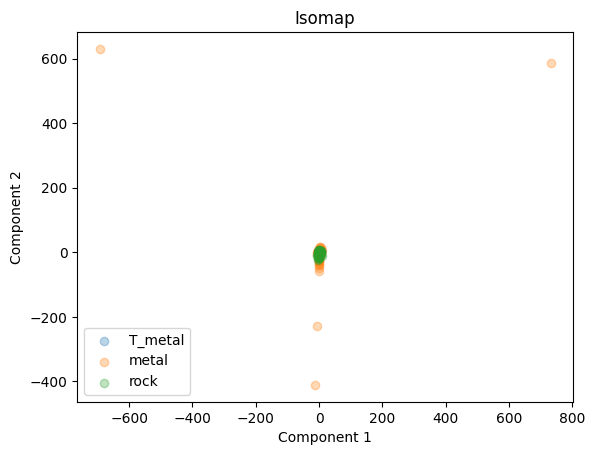

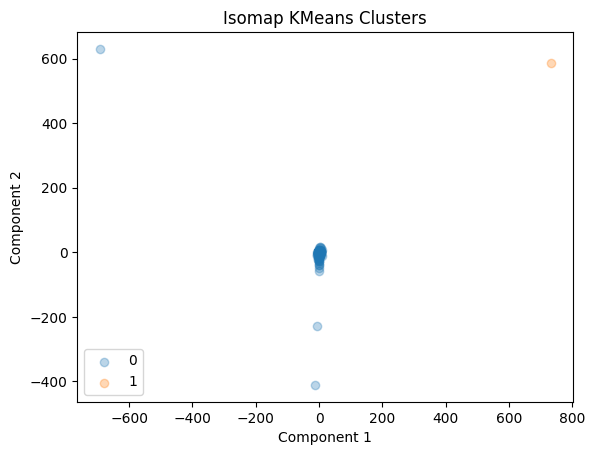

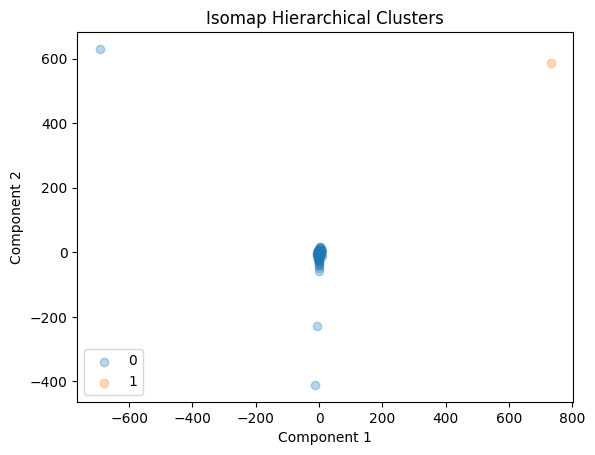

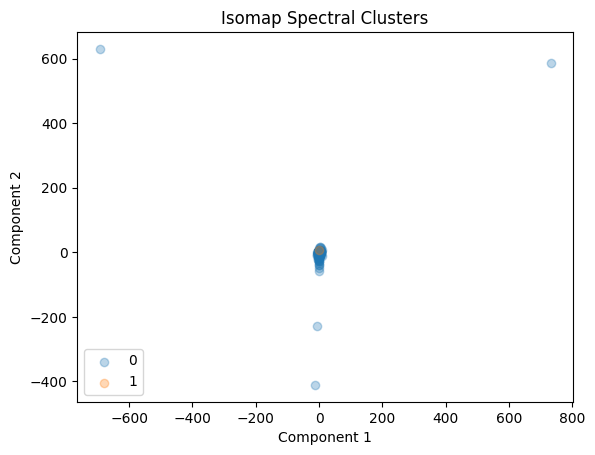

In [32]:
make_plots(isomap_X, y, isomap_clusters, isomap_ward_labels, isomap_spec_clust, 'Isomap')

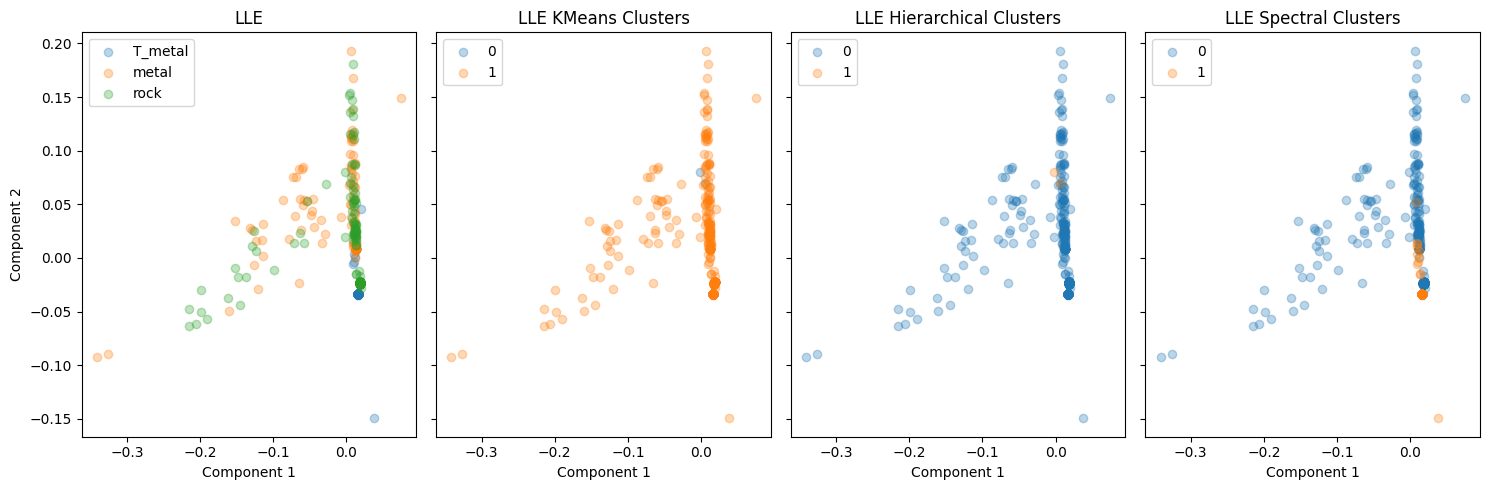

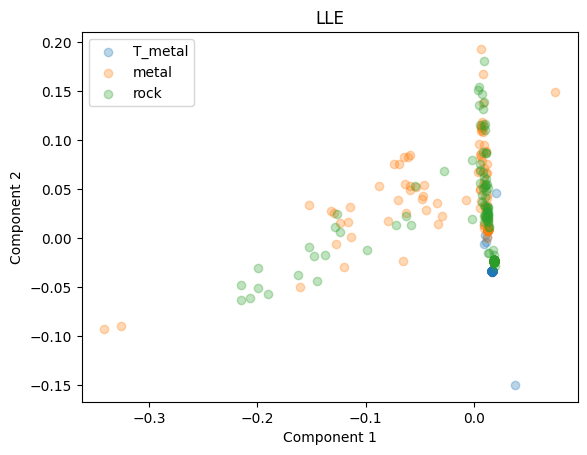

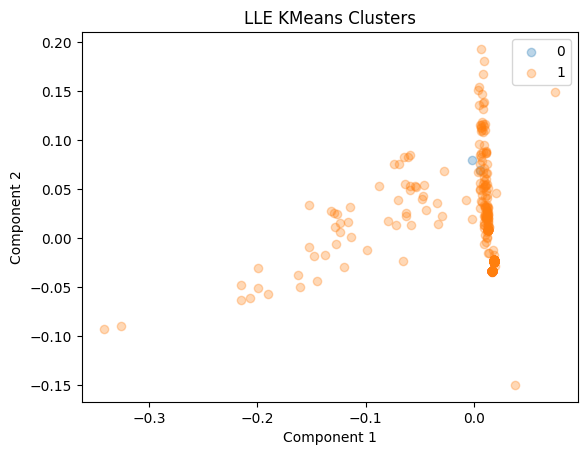

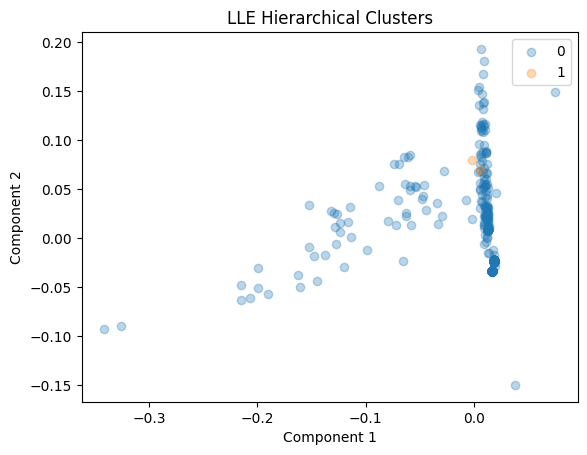

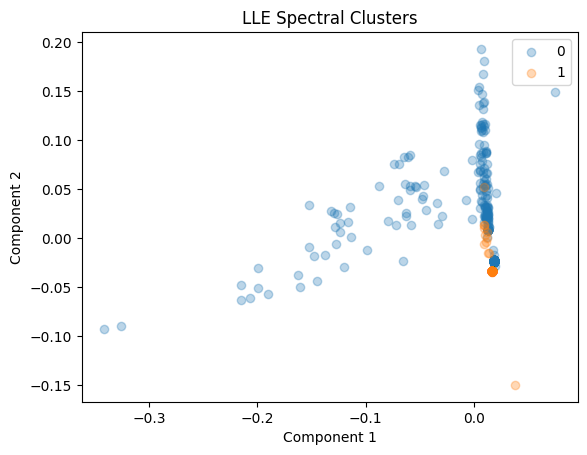

In [33]:
make_plots(lle_X, y, lle_clusters, lle_ward_labels, lle_spec_clust, 'LLE')